# Plot Debugging

I am noticing some wierd things in the plots, and I am going to attempt to fix them on this branch:
- #41, it seems like the ball and the players are on different time scales?
- #14, the event only shows up for one frame

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os

# Matt written files
from src.utils import *
from src.plotting import Baseball_Field
from src.game import Game

In [2]:
# pandas options
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

Example plays are 
- 326
- 18

Distance between ball and player is large on average, should maybe clean up 12.199183415462679


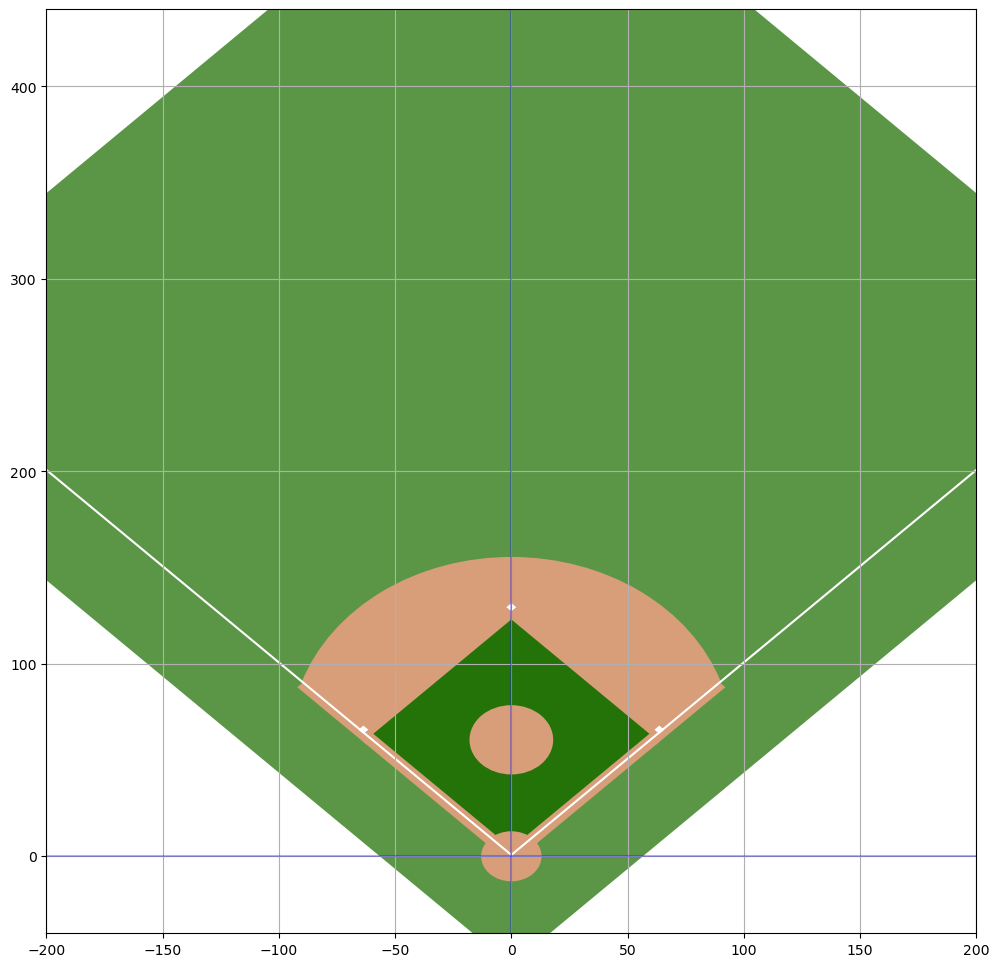

In [3]:
bf_1903_01 = Baseball_Field("1903_01_TeamNE_TeamA2")

In [5]:
bf_1903_01.clear_plot()

play_id = 124

#bf_1903_01.plot_all_components(play_id=play_id)
#bf_1903_01.fig

bf_1903_01.create_gif(play_id=play_id, tag="--debugging, merge w players")

MovieWriter ffmpeg unavailable; using Pillow instead.


In [ ]:
game_events_1903_01 = bf_1903_01.game_obj.game_events_df.copy()
game_info_1903_01 = bf_1903_01.game_obj.game_info_df.copy()
player_pos_1903_01 = bf_1903_01.game_obj.new_player_pos.copy()
ball_pos_1903_01 = bf_1903_01.game_obj.ball_pos_df.copy()



game_events_1903_01.head(2)

In [ ]:
game_events_1903_01[game_events_1903_01["play_id"] == 326]

In [ ]:
ball_pos_1903_01.loc[(ball_pos_1903_01["play_id"] == 326)
                       , :]

In [ ]:
player_pos_1903_01.loc[(player_pos_1903_01["play_id"] == 18) &
                       (player_pos_1903_01["player_position"] == 6), :]

In [ ]:
game_events_1903_01.loc[(game_events_1903_01["play_id"] == 326) &
                        (game_events_1903_01["event"].isin(["ball acquired", "throw (ball-in-play)"])), ]

In [ ]:
plt.close()

In [ ]:
## stretch the ball pos to the player pos

# trust the ball pos at ball acquired

# trust which time scale? I think the ball probably
play_id = 326

ball_acq = game_events_1903_01.loc[
    (game_events_1903_01["play_id"] == play_id) &
    (game_events_1903_01["event"] == "ball acquired")
    , "timestamp"
].values[0]


this_play_ball = ball_pos_1903_01.loc[ball_pos_1903_01["play_id"] == play_id]
this_play_ball["this_play_ms"] = this_play_ball.timestamp - this_play_ball.timestamp.min()


first_ball_acq_x = ball_pos_1903_01.loc[ball_pos_1903_01["timestamp"] == ball_acq, "ball_position_x"]


this_play_players = player_pos_1903_01.loc[
    (player_pos_1903_01["play_id"] == play_id) &
    (player_pos_1903_01["player_position"] == 5)
    , :]

this_play_players["this_play_ms"] = this_play_players.timestamp - this_play_players.timestamp.min()


overlap_ms_players = this_play_players.loc[
    (abs(this_play_players["field_x"] - first_ball_acq_x.values[0]) < 1)
    , "this_play_ms"].values[0]


overlap_ms_ball = this_play_ball.loc[this_play_ball["timestamp"] == ball_acq, "this_play_ms"].values[0]


time_delta = overlap_ms_players - overlap_ms_ball

In [ ]:
time_delta

In [ ]:
f, ax = plt.subplots()



ax.plot(this_play_players["this_play_ms"], this_play_players["field_x"], color = "orange", label="player") 
ax.plot(this_play_ball["this_play_ms"]+time_delta, this_play_ball["ball_position_x"], color = "blue", label="ball") 

ax.legend()

In [ ]:
this_play_players.timestamp.min() - this_play_ball.timestamp.min()

### Do the above procedure for every play!

In [ ]:
def line_up_ball_and_players():
    pass

In [ ]:
# get the first ball acq in ever event

In [ ]:
# Fill the timestamp for each play


##
this_play_players["this_play_ms"] = this_play_players.timestamp - this_play_players.timestamp.min()

#

this_play_ball["this_play_ts"] = np.nan
this_play_ball["adjusted_play_ts"] = np.nan

this_play_ball["this_play_ts"] = this_play_ball.timestamp - this_play_ball.timestamp.min()


In [ ]:
# get the player and time that the ball was first acquired
ball_acq_event = game_events_1903_01.loc[
    game_events_1903_01["event"] == "ball acquired"
].groupby("play_id")[["player_position", "timestamp"]].first()


In [ ]:
# get ball_position of the first ball acq for each play
first_ball_acq_pos = ball_pos_1903_01.merge(
    ball_acq_event, 
    how="inner", 
    on=["play_id", "timestamp"]
)[["play_id", "ball_position_x", "ball_position_y"]]

In [ ]:
# get the player_pos for each player that first acquires the ball for each play
player_pos_first_acq = player_pos_1903_01.merge(
    ball_acq_event, 
    how="inner", 
    on=["play_id", "player_position"], 
    suffixes=["", "_ball_first_acq"]
)

In [ ]:
# dist margin, how far we allow the play to be off
# 3 is roughly an arms length, could do better with limb data
margin = 3


# merge the ball pos when first acquired and player dfs
combined_first_acq = player_pos_first_acq.merge(first_ball_acq_pos, on="play_id", how="left")

# get the distance between the ball and player who acquired
combined_first_acq["delta_dist"] = np.sqrt(
    (combined_first_acq["field_x"] - combined_first_acq["ball_position_x"])**2 +\
    (combined_first_acq["field_y"] - combined_first_acq["ball_position_y"])**2                                    
)

# could totally do a more complex min here, e.g. with fill x and y
# I think the raw min won't work, so have a margin
# and pick the first time this happens
when_within_margin = combined_first_acq[combined_first_acq["delta_dist"] < margin].groupby("play_id").first()

# pick a looser margin for the other ones that don't work
# so we at least have coverage
plays_that_not_within_margin = set(combined_first_acq["play_id"].unique()) - set(when_within_margin.index)

not_within_margin = combined_first_acq.loc[
    (combined_first_acq["play_id"].isin(plays_that_not_within_margin)) &
    (combined_first_acq["delta_dist"] < 2*margin)
].groupby("play_id").first()

all_plays = pd.concat([not_within_margin, when_within_margin]).sort_values("play_id")

# compute the lags needed for each play to line up the ball with the player + 3 ft
ts_lag_df = (all_plays["timestamp"] - all_plays["timestamp_ball_first_acq"])
ts_lag_df.name = "time_offset"

In [ ]:
ts_lag_df.describe()

In [ ]:
# do the computing of new timestamps for ball

ball_pos_1903_01["old_ts"] = ball_pos_1903_01["timestamp"]


# merge only the positive, because the others are probs 
# just the ball getting to the front of someone
new_ball_pos_1903_01 = ball_pos_1903_01.merge(ts_lag_df[ts_lag_df > 0], 
                       how = "left", 
                       left_on="play_id",
                       right_on="play_id"
)


new_ball_pos_1903_01["timestamp"] = new_ball_pos_1903_01.apply(
    lambda row:                                           
    row["old_ts"] + (row["time_offset"] if pd.notnull(row["time_offset"]) else 0),
    axis=1
)


In [ ]:
new_ball_pos_1903_01.loc[new_ball_pos_1903_01["timestamp"] != new_ball_pos_1903_01["old_ts"], "play_id"].unique()

In [ ]:
np.isnan()

### verify that this works before adding this into Game

In [ ]:
play_id = 1

this_play_ball = ball_pos_1903_01.loc[ball_pos_1903_01["play_id"] == play_id]

this_play_players = player_pos_1903_01.loc[
    (player_pos_1903_01["play_id"] == play_id) &
    (player_pos_1903_01["player_position"] == ball_acq_event.loc[play_id, "player_position"])
    , :]

f, ax = plt.subplots()

ax.plot(this_play_players["timestamp"], this_play_players["field_x"], color = "orange", label="player") 
ax.plot(this_play_ball["timestamp"], this_play_ball["ball_position_x"], linestyle="dotted", color = "blue", label="ball_without_lag") 


ax.plot(this_play_ball["timestamp"] + ts_lag_df[play_id], this_play_ball["ball_position_x"], color = "blue", label="ball") 

ax.set_title("Lag of {}".format(ts_lag_df[play_id]))

ax.legend()

### Things that need to happen to merge this with Game

- add the procedure I just made
- use that to reset the timestamps for ball
    - map the old ts to a variable called "old_ts"
- Recompute the ball preprocessing stuff, or just order it so it doesn't happed the first time?


Not as critical, but could be a helper:
- add a "this_play_ts" in player_pos and ball_pos

```python
# get the timestamps of the play where 0 is the start of the play
ball_pos_1903_01 = ball_pos_1903_01.merge(ball_pos_1903_01.groupby("play_id")["timestamp"].min(), on="play_id", suffixes=["", "_play_min"])
ball_pos_1903_01["this_play_ts"] = ball_pos_1903_01["timestamp"] - ball_pos_1903_01["timestamp_play_min"]
```



### I THINK IT IS JUST A CONSTANT FACTOR PER GAME?
- It seems like most games this is not a problem from looking at some gifs?

### Double check whether it is a constant factor per game by running this

In [ ]:
bf_09 = Baseball_Field("1903_09_TeamNJ_TeamB")

In [ ]:
game_events_09 = bf_09.game_obj.game_events_df.copy()
game_info_09 = bf_09.game_obj.game_info_df.copy()
player_pos_09 = bf_09.game_obj.new_player_pos.copy()
ball_pos_09 = bf_09.game_obj.ball_pos_df.copy()


In [ ]:
game_events_09[game_events_09["event"] == "throw (ball-in-play)"].head(3)

In [ ]:
bf_09.clear_plot()

play_id = 24

# bf_09.plot_all_components(play_id=play_id)
# bf_09.fig

# bf_09.create_gif(play_id=play_id, tag="--debugging, markers are off")

In [ ]:
## stretch the ball pos to the player pos

# trust the ball pos at ball acquired

# trust which time scale? I think the ball probably
play_id = 15

ball_acq = game_events_09.loc[
    (game_events_09["play_id"] == play_id) &
    (game_events_09["event"] == "ball acquired")
    , "timestamp"
].values[0]


this_play_ball = ball_pos_09.loc[ball_pos_09["play_id"] == play_id]
this_play_ball["this_play_ms"] = this_play_ball.timestamp - this_play_ball.timestamp.min()


first_ball_acq_x = ball_pos_09.loc[ball_pos_09["timestamp"] == ball_acq, "ball_position_x"]


this_play_players = player_pos_09.loc[
    (player_pos_09["play_id"] == play_id) &
    (player_pos_09["player_position"] == 6)
    , :]

this_play_players["this_play_ms"] = this_play_players.timestamp - this_play_players.timestamp.min()


overlap_ms_players = this_play_players.loc[
    (abs(this_play_players["field_x"] - first_ball_acq_x.values[0]) < 1)
    , "this_play_ms"].values[0]


overlap_ms_ball = this_play_ball.loc[this_play_ball["timestamp"] == ball_acq, "this_play_ms"].values[0]


time_delta = overlap_ms_players - overlap_ms_ball

In [ ]:
time_delta

In [ ]:
bf_09.clear_plot()
plt.close()

f, ax = plt.subplots()

play_id = 15

thirdbaseman_df = player_pos_09.loc[(player_pos_09["play_id"] == play_id) &
                       (player_pos_09["player_position"] == 6), :]


ball_df = ball_pos_09.loc[(ball_pos_09["play_id"] == play_id)
                       , :]

ax.plot(thirdbaseman_df["timestamp"], thirdbaseman_df["field_x"], color = "orange", label="player") 
ax.plot(ball_df["timestamp"]+3000, ball_df["ball_position_x"], color = "blue", label="ball") 
ax.legend()

f

### The one has a smaller dist Which game: 1900_03_TeamKJ_TeamB

In [ ]:
# Check whether 3000 is still the correct buffer?
bf_03 = Baseball_Field("1903_05_TeamND_TeamA2")

In [ ]:
game_events_03 = bf_03.game_obj.game_events_df.copy()
game_info_03 = bf_03.game_obj.game_info_df.copy()
player_pos_03 = bf_03.game_obj.new_player_pos.copy()
ball_pos_03 = bf_03.game_obj.ball_pos_df.copy()


In [ ]:
game_events_03[game_events_03["event"] == "throw (ball-in-play)"].head(3)

In [ ]:
bf_03.clear_plot()
plt.close()

f, ax = plt.subplots()

play_id = 46

thirdbaseman_df = player_pos_03.loc[(player_pos_03["play_id"] == play_id) &
                       (player_pos_03["player_position"] == 7), :]


ball_df = ball_pos_03.loc[(ball_pos_03["play_id"] == play_id)
                       , :]

ax.plot(thirdbaseman_df["timestamp"], thirdbaseman_df["field_x"], color = "orange", label="player") 
ax.plot(ball_df["timestamp"] +3000, ball_df["ball_position_x"], color = "blue", label="ball") 
ax.legend()

f

In [ ]:
bf_03.clear_plot()

play_id = 46

bf_03.plot_all_components(play_id=play_id)
bf_03.fig

# bf_03.create_gif(play_id=play_id, tag="--debugging, no clue")

## See a play that works, before I go messing with things

1903_23_TeamNA_TeamA1_play148--steal, not picked

In [ ]:
bf_23 = Baseball_Field("1903_23_TeamNA_TeamA1")

In [ ]:
game_events_23 = bf_23.game_obj.game_events_df.copy()
game_info_23 = bf_23.game_obj.game_info_df.copy()
player_pos_23 = bf_23.game_obj.new_player_pos.copy()
ball_pos_23 = bf_23.game_obj.ball_pos_df.copy()

game_events_23.head(5)

In [ ]:
bf_23.clear_plot()
plt.close()

f, ax = plt.subplots()

play_id = 148

thirdbaseman_df = player_pos_23.loc[(player_pos_23["play_id"] == play_id) &
                       (player_pos_23["player_position"] == 2), :]


ball_df = ball_pos_23.loc[(ball_pos_23["play_id"] == play_id)
                       , :]

ax.plot(thirdbaseman_df["timestamp"], thirdbaseman_df["field_x"], color = "orange", label="player") 
ax.plot(ball_df["timestamp"], ball_df["ball_position_x"], color = "blue", label="ball") 
ax.legend()

f

In [ ]:
check_positions_when_acquired(game_events_23, ball_pos_23, player_pos_23)

In [ ]:
plt.close()

In [ ]:
game_events_23[game_events_23["event"] == "throw (ball-in-play)"]

In [ ]:
## make some gifs to see if I need to time correct?

bf_23.clear_plot()

play_id = 196

# bf_23.plot_all_components(play_id=play_id)
# bf_23.fig

# bf_23.create_gif(play_id=play_id, tag="--debugging")

## See how many I would like to line up
to see if it is worth writing that function to line things up
- there are 7 of the games that aren't erroring, so I think I should do this

In [ ]:
all_games = get_all_game_strs()

In [ ]:
for which_game in all_games:
    if which_game in ["1902_19_TeamME_TeamA2", "1902_13_TeamMD_TeamA2", "1902_03_TeamMG_TeamA3", "1901_13_TeamLL_TeamB",
                     "1902_18_TeamMB_TeamA1", "1900_02_TeamKJ_TeamB", "1901_06_TeamLI_TeamA3", "1902_27_TeamMH_TeamA3",
                     "1902_13_TeamMK_TeamB", "1903_27_TeamNH_TeamA3", "1902_07_TeamMJ_TeamB", "1902_20_TeamME_TeamA2",
                     "1902_30_TeamMF_TeamA2", "1901_05_TeamLI_TeamA3", "1901_17_TeamLH_TeamA3", "1902_21_TeamME_TeamA2",
                     ""]:
        continue
    
    print("Which game: {}".format(which_game))
    
    g = Game(which_game)
